![header](../figures/logos_partenaires._cmems_se.jpg)

# Gulf Stream: Benchmark DUACS sea surface height maps
 

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Gulf Stream: Benchmark of DUACS sea surface height maps</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by the DUACS system. </h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the independent SSH data from the Saral/AltiKa altimeter distributed by CMEMS </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated sea surface height maps with independent alongtrack data: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os

In [2]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [4]:
time_min = '2019-01-15'                                        # time min for analysis
time_max = '2019-12-15'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')

# West Med region
region = 'WM'
lon_min = 1                                          # domain min longitude
lon_max = 20                                          # domain max longitude
lat_min = 30.                                          # domain min latitude
lat_max = 45.                                          # domain max latitude
box_lonlat_WM = {'lon_min':lon_min,'lon_max':lon_max,'lat_min':lat_min,'lat_max':lat_max}

method_name = 'DUACS'

stat_output_filename = f'{output_dir}/stat_sla_duacs_WM.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_sla_duacs_WM.nc'    # output spectral analysis filename
segment_lenght = 1000.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [5]:
%%time
list_of_file = sorted(glob('../data/independent_alongtrack/alg/2019/dt_*'))
ds_alg = xr.open_mfdataset(list_of_file, combine='nested', concat_dim='time')
ds_alg = ds_alg.where((ds_alg.time >= np.datetime64(time_min)) & (ds_alg.time <=  np.datetime64(time_max)), drop=True)
ds_alg = ds_alg.sortby('time')
ds_alg

CPU times: user 58.5 s, sys: 7.41 s, total: 1min 5s
Wall time: 1min 25s


<xarray.Dataset>
Dimensions:         (time: 13144851)
Coordinates:
  * time            (time) datetime64[ns] 2019-01-15T00:00:01.052876032 ... 2...
    longitude       (time) float64 dask.array<chunksize=(45359,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(45359,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(45359,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(45359,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    ocean_tide      (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    internal_tide   (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    tpa_correction  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P24H11M29.716548S
    time_coverage_end:               2019-01-01T23:36:52Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2018-12-31T23:25:22Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

## Sea Surface Height maps to evaluate

In [6]:
%%time
list_of_maps = sorted(glob('../data/maps/DUACS_global_allsat-alg/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

CPU times: user 8.61 s, sys: 1.13 s, total: 9.74 s
Wall time: 13.9 s


<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, time: 335)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float64 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 2019-01-15 2019-01-16 ... 2019-12-15
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

## Selecting only West Mediterranean

In [7]:

from src.mod_compare import regional_zoom

ds_maps = regional_zoom(ds_maps, [box_lonlat_WM['lon_min'],box_lonlat_WM['lon_max']], [box_lonlat_WM['lat_min'],box_lonlat_WM['lat_max']], namelon='longitude', namelat='latitude', change_lon=True)
ds_maps

<xarray.Dataset>
Dimensions:    (time: 335, latitude: 60, longitude: 76)
Coordinates:
  * latitude   (latitude) float32 30.12 30.38 30.62 30.88 ... 44.38 44.62 44.88
  * longitude  (longitude) float64 1.125 1.375 1.625 1.875 ... 19.38 19.62 19.88
  * time       (time) datetime64[ns] 2019-01-15 2019-01-16 ... 2019-12-15
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(1, 60, 76), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [8]:
ds_interp = run_interpolation(ds_maps, ds_alg)
ds_interp = ds_interp.dropna('time')
ds_interp

2023-10-05 09:37:53 INFO     fetch data from 2019-01-15 00:00:00 to 2019-02-01 00:00:00
2023-10-05 09:37:54 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2023-10-05 09:37:56 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2023-10-05 09:37:58 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2023-10-05 09:38:05 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2023-10-05 09:38:09 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2023-10-05 09:38:12 INFO     fetch data from 2019-06-30 00:00:00 to 2019-08-01 00:00:00
2023-10-05 09:38:17 INFO     fetch data from 2019-07-31 00:00:00 to 2019-09-01 00:00:00
2023-10-05 09:38:20 INFO     fetch data from 2019-08-31 00:00:00 to 2019-10-01 00:00:00
2023-10-05 09:38:22 INFO     fetch data from 2019-09-30 00:00:00 to 2019-11-01 00:00:00
2023-10-05 09:38:24 INFO     fetch data from 2019-10-31 00:00:00 to 2019-12-01 00:00:00
2023-10-05 09:38:26 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 54130)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-15T04:17:22.555794176 .....
Data variables: (12/13)
    cycle              (time) float64 126.0 126.0 126.0 ... 135.0 135.0 135.0
    track              (time) float64 415.0 415.0 415.0 ... 929.0 929.0 929.0
    sla_unfiltered     (time) float32 0.171 0.083 0.114 ... 0.112 0.109 0.111
    sla_filtered       (time) float32 0.128 0.129 0.131 ... 0.122 0.116 0.11
    dac                (time) float32 0.067 0.066 0.066 ... -0.117 -0.122 -0.126
    ocean_tide         (time) float32 -0.01 -0.01 -0.01 ... 0.008 0.002 -0.004
    ...                 ...
    lwe                (time) float32 -0.038 -0.039 -0.039 ... 0.024 0.024 0.024
    mdt                (time) float32 0.013 0.012 0.01 ... -0.09 -0.091 -0.092
    tpa_correction     (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 19.87 19.85 19.84 ... 12.67 12.64 12.62
    latitude           (time) float64 31.34 31.4 31.46 ... 44.72 44.78 44.84
    msla_interpolated  (time) float64 0.1189 0.12 0.1177 ... 0.111 0.1144 0.1215

In [34]:
np.sqrt(np.nanmean((ds_interp.sla_unfiltered-ds_interp.msla_interpolated)**2))

0.027242944645821388

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the maps have been interpolated to the position of the along-track, it is possible to calculate different statistics on the time series SLA_alongtrack and SLA_maps. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps, temporal evolution of global error variance and explained variance. 

These statistics are also applied to the filtered signals focusing on the 65-500km scale range. A bandpass filter is applied before calculating the scores.  

In [9]:
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename,method_name)

2023-10-05 09:38:28 INFO     Compute mapping error all scales
2023-10-05 09:38:29 INFO     Compute mapping error for scales between 65.0 and 500.0 km
2023-10-05 09:38:29 INFO     Compute binning statistics
2023-10-05 09:38:31 INFO     Compute statistics by oceanic regime
2023-10-05 09:38:54 INFO     Stat file saved as: ../results/stat_sla_duacs_WM.nc


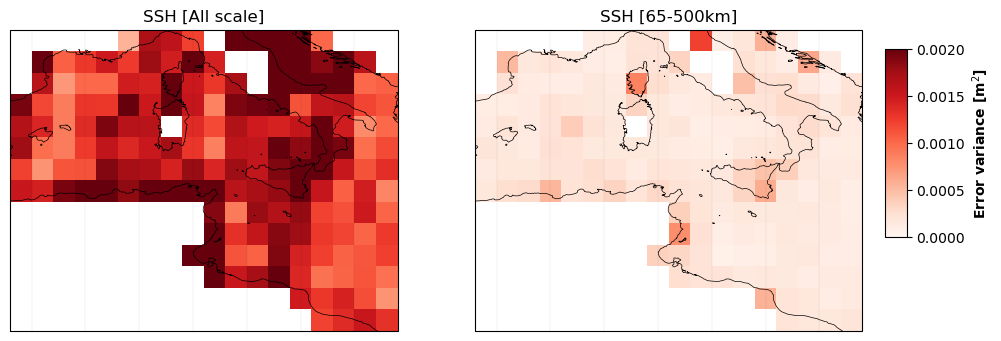

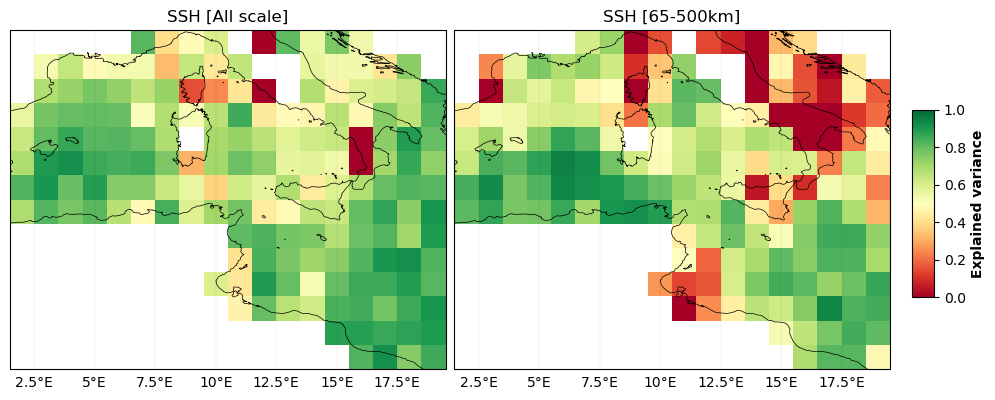

In [10]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map(stat_output_filename)
# Matplotlib
plot_stat_score_map_png(stat_output_filename,region=region,box_lonlat=box_lonlat_WM)

In [11]:
plot_stat_score_timeseries(stat_output_filename)

:Layout
   .Overlay.I  :Overlay
      .Curve.All_scale :Curve   [time]   (timeserie_variance_mapping_err)
      .Curve.Filtered  :Curve   [time]   (timeserie_variance_mapping_err)
   .Overlay.II :Overlay
      .Curve.All_scale :Curve   [time]   (explained_variance_score)
      .Curve.Filtered  :Curve   [time]   (explained_variance_score)

In [12]:
plot_stat_by_regimes(stat_output_filename)

,mapping_err_var [m²],sla_unfiltered_var [m²],mapping_err_filtered_var [m²],sla_filtered_var [m²],var_score_allscale,var_score_filtered
coastal,0.001579,0.006338,0.000186,0.000757,0.750817,0.754118
offshore_highvar,NaN,NaN,NaN,NaN,NaN,NaN
offshore_lowvar,0.001164,0.008435,0.000118,0.000709,0.861954,0.833906
equatorial_band,NaN,NaN,NaN,NaN,NaN,NaN
arctic,NaN,NaN,NaN,NaN,NaN,NaN
antarctic,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3 Compute Spectral scores

In [13]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght,method_name=method_name)

2023-10-05 09:39:03 INFO     Segment computation...
2023-10-05 09:39:03 INFO     Spectral analysis...
2023-10-05 09:39:06 INFO     Saving ouput...
2023-10-05 09:39:12 INFO     PSD file saved as: ../results/psd_sla_duacs_WM.nc


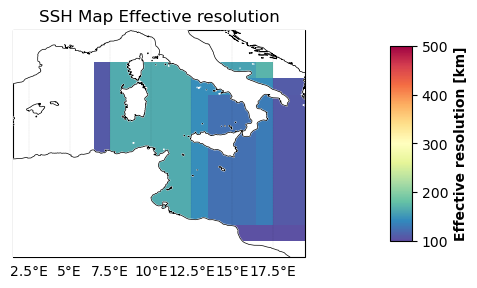

In [14]:
# Plot effective resolution
# Hvplot
# plot_effective_resolution(psd_output_filename)
# Matplotlib
plot_effective_resolution_png(psd_output_filename,region=region,box_lonlat=box_lonlat_WM)

In [30]:
ds_psd=xr.open_dataset(psd_output_filename)
wavenum = np.array(ds_psd.wavenumber)
psd_ref = np.mean(np.mean(ds_psd.psd_ref,2),1)
psd_study = np.mean(np.mean(ds_psd.psd_study,2),1)

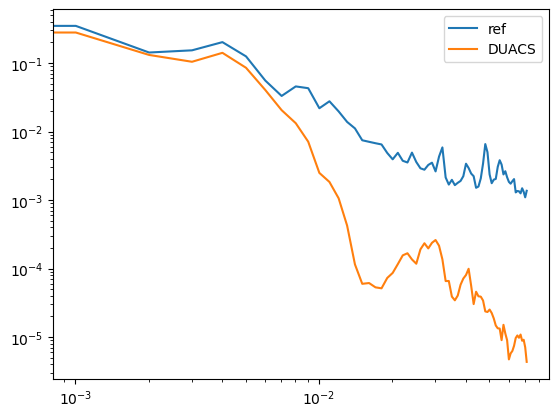

In [32]:
plt.loglog(wavenum,psd_ref,label='ref')
plt.loglog(wavenum,psd_study,label='DUACS')
plt.legend()

In [15]:
plot_psd_scores(psd_output_filename)

:Layout
   .DynamicMap.I   :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_alongtrack   :Curve   [wavelenght]   (psd_ref)
         .Curve.NOISE_alongtrack :Curve   [wavelenght]   (noise)
         .Curve.PSD_map          :Curve   [wavelenght]   (psd_study)
         .Curve.PSD_err          :Curve   [wavelenght]   (psd_diff)
   .DynamicMap.II  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_map_over_PSD_ref :Curve   [wavelenght]   (psd_ratio)
         .Curve.I                    :Curve   [wavelenght]   (coherence)
   .DynamicMap.III :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (psd_score)
         .Curve.II :Curve   [wavelenght]   (coherence)
   .DynamicMap.IV  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (coherence)
         .Curve.II :Curve   [wavelenght]   (coherence)

The interactive plot above allows you to explore the spectral metrics by latitude / longitude box

In [16]:
ds_mdt = xr.open_dataset('/Users/sammymetref/Documents/DATLAS/Data/cnes_obs-sl_glo_phy-mdt_my_0.125deg_P20Y_1695393893725_1mdt.nc')

In [17]:
ds_mdt = xr.open_dataset('/Users/sammymetref/Documents/DATLAS/Data/cnes_obs-sl_glo_phy-mdt_my_0.125deg_P20Y_1695393893725_1mdt.nc')
ds_mdt = regional_zoom(ds_mdt, [box_lonlat_WM['lon_min'],box_lonlat_WM['lon_max']], [box_lonlat_WM['lat_min'],box_lonlat_WM['lat_max']], namelon='longitude', namelat='latitude', change_lon=True)
ds_mdt

<xarray.Dataset>
Dimensions:    (longitude: 152, latitude: 120)
Coordinates:
  * latitude   (latitude) float32 30.06 30.19 30.31 30.44 ... 44.69 44.81 44.94
    time       datetime64[ns] 2003-01-01
  * longitude  (longitude) float32 1.062 1.188 1.312 1.438 ... 19.69 19.81 19.94
Data variables:
    crs        (longitude, latitude) float64 -2.147e+09 ... -2.147e+09
    mdt        (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/40)
    cdm_data_type:                                  Grid
    history:                                        2020-07-29T10:52:01Z : Cr...
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P20Y
    time_coverage_start:                            1993-01-01T00:00:00Z
    time_coverage_resolution:                       P20Y
    time_coverage_end:                              2013-01-01T00:00:00Z
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...
    comment:

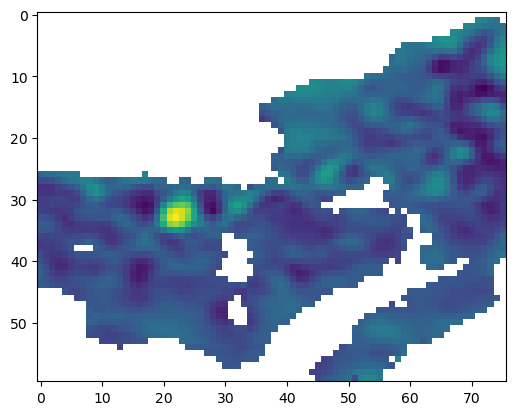

In [18]:
plt.imshow(ds_maps.sla[0,:,:])

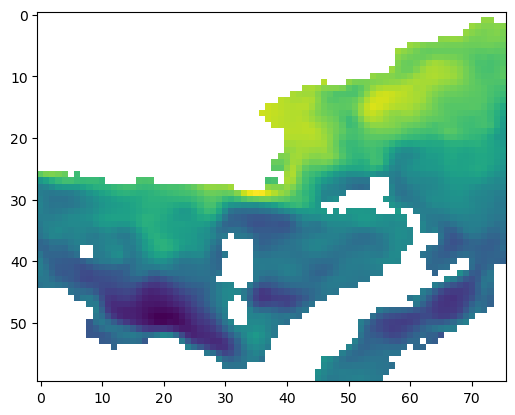

In [19]:
plt.imshow(ds_mdt.mdt[::2,::2])

In [20]:
ds_maps = ds_maps.assign(ssh=lambda ds_maps: ds_maps.sla + 0 )

In [21]:
np.shape(ds_mdt.mdt.values[::2,::2])

(60, 76)

In [22]:
mdt_2 = np.array(ds_mdt.mdt[::2,::2].values)

In [23]:
mdt_2

array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ..., 0.0313,    nan,    nan],
       [   nan,    nan,    nan, ..., 0.025 , 0.0269, 0.0265],
       ...,
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan]])

In [24]:
for i in range(ds_maps.time.size): 
    print(i)
    ds_maps['ssh'][i,:,:] += mdt_2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
np.nanmax(ds_maps['sla'][2,:,:])

0.327

In [26]:
np.nanmax(ds_maps['ssh'][2,:,:])

0.2741

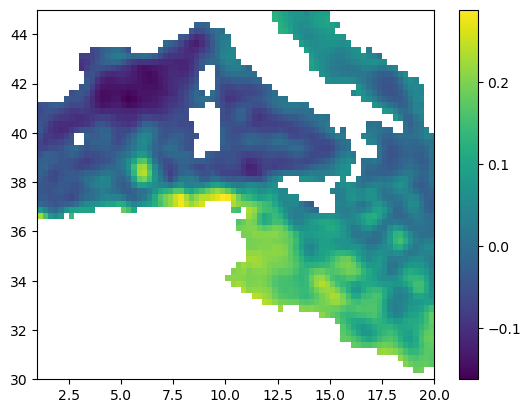

In [27]:
plt.pcolormesh(ds_maps.longitude,ds_maps.latitude,ds_maps.ssh[20,:,:])
plt.colorbar()

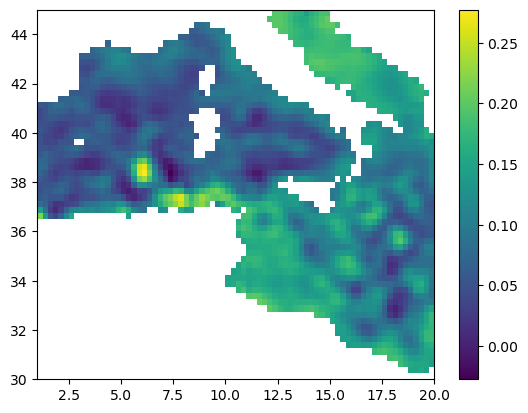

In [28]:
plt.pcolormesh(ds_maps.longitude,ds_maps.latitude,ds_maps.sla[20,:,:])
plt.colorbar()

In [29]:
#ds_maps.to_netcdf('/Users/sammymetref/Documents/DATLAS/Data/DUACS_DC_Glob_ssh_Med.nc')